In [1]:
"""Perfoms basic data mining on the input 3D dataset.
Notebook contains various dataset analysis & various segmentation mask pre-processing options.
"""

'Perfoms basic data mining on the input 3D dataset.\nNotebook contains various dataset analysis & various segmentation mask pre-processing options.\n'

In [2]:
import pathlib
import config
from sklearn.metrics import jaccard_score
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import dataset as dataset
from torchvision import transforms
import numpy as np
from skimage import transform as trans
from skimage import io

In [3]:
def print_image_data(img: np.ndarray):
    """Prints basic data about an image array.
    """
    print('Shape of input image: ', img.shape)
    print('Data type: ', img.dtype)
    print('Max element: ', img.max())
    print('Min element: ', img.min())
    print('Total number of elements: ', img.size)
    print('Number of unique elements: ', np.unique(img).size)
    print('Average value: ', np.average(img))

In [25]:
def rgb_to_onehot(rgb_arr: np.ndarray, color_dict: dict) -> np.ndarray:
    """Converts an RGB image into one-hot-encoded 
    multidimensional array, with shape CxHxW, 
    C being the number of classes.

    Args:
        rgb_arr: Input RGB image.
        color_dict: Dictionary that maps RGB colors to classes with
                    integer keys (0, 1, 2, ...) mapped to RGB color tuples.

    Returns:
        Output one-hot-encoded array. 
    """
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros(shape, dtype=np.int8)
    
    # Use more robust color matching with tolerance for compression artifacts
    for i, color in enumerate(color_dict.values()):
        # Calculate Euclidean distance to handle slight variations from resizing/compression
        color_array = np.array(color)
        rgb_reshaped = rgb_arr.reshape((-1, 3))
        
        # Use a small tolerance for color matching (handles compression artifacts)
        distances = np.linalg.norm(rgb_reshaped - color_array, axis=1)
        tolerance = 10  # Allow small variations due to resizing/compression
        matches = distances <= tolerance
        
        arr[:, :, i] = matches.reshape(shape[:2])
    
    return arr

In [26]:
def onehot_to_rgb(onehot: np.ndarray, color_dict: dict) -> np.ndarray:
    """Converts one-hot-encoded RBG image back to the RGB array.

    Args:
        onehot: One-hot-encoded RGB image, with shape CxHxW, C being the number
                of classes.
        color_dict: Dictionary that maps RGB colors to classes with
                    index-colour key-value pairs. Indices  should be
                    numerated from 0 to n_classes.

    Returns:
       RGB image. 
    """
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros(onehot.shape[:2]+(3,))
    
    for k in color_dict.keys():
        output[single_layer==k]=color_dict[k]
        
    return np.uint8(output)

In [27]:
# Load global config.
config_file = config.Config()

# Basic data exploration.

In [28]:
# Load the train dataset with applied transformations.
data_dir = pathlib.Path(config_file.config["dataset"]["train"]["image"])
mask_dir = pathlib.Path(config_file.config["dataset"]["train"]["mask"])
# Get a list of names of the contents of the folder.
all_images=list(path.name for path in pathlib.Path.iterdir(data_dir))

train_image,eval_image=train_test_split(all_images,train_size=0.8,test_size=0.2) 

train_transforms=transforms.Compose([dataset.OneHotEncodeMask(dataset.COLOR_DICT), 
                                     dataset.Resize(config_file.config["output_size"]),dataset.ToTensor()]) 

train_set=dataset.SegMaskDataset(data_dir,mask_dir,train_image,eval_image,train=True,transforms=train_transforms)
valid_set=dataset.SegMaskDataset(data_dir,mask_dir,train_image,eval_image,train=False, transforms=train_transforms)

In [29]:
sample = train_set[1]

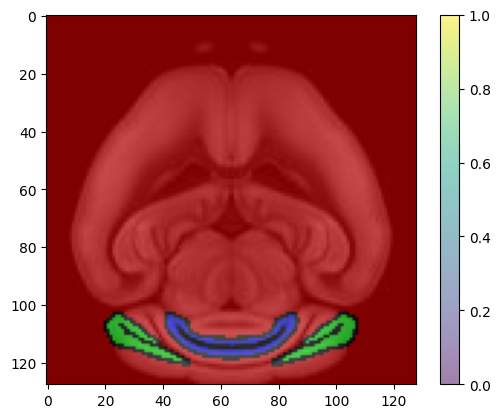

In [30]:
# Display 1 data sample & with it's mask.
img=sample['image'].numpy().transpose(1,2,0)
msk=sample['mask'].numpy().transpose(1,2,0)
plt.imshow(img)
plt.imshow(msk, alpha=0.5)
plt.colorbar()

Shape of input image:  (128, 128, 3)
Data type:  float64
Max element:  0.6588235294117647
Min element:  0.0
Total number of elements:  49152
Number of unique elements:  169
Average value:  0.20441128599877453


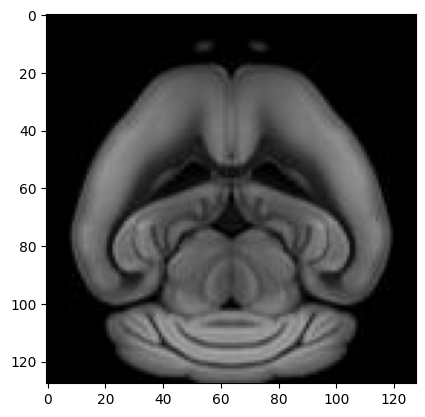

In [31]:
# Display image & it's info.
plt.imshow(img)
print_image_data(img)

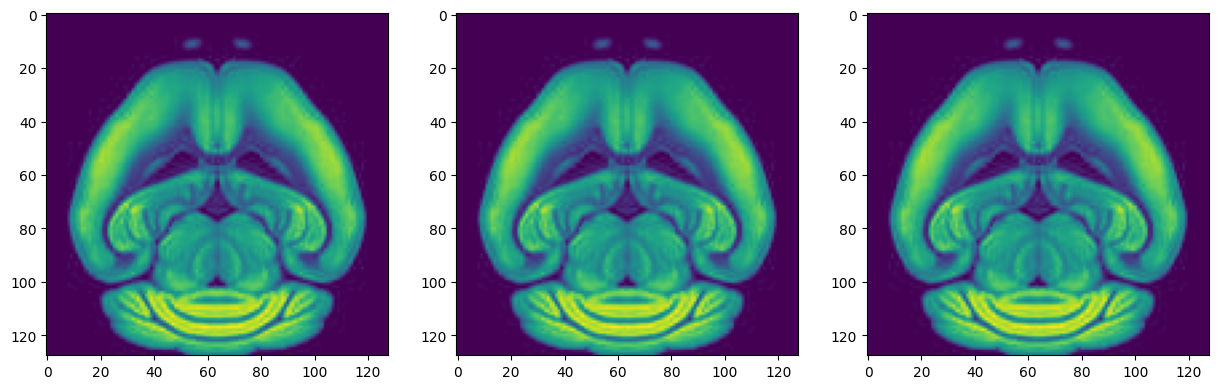

In [32]:
# Display all 3 channels.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(img[:, :, 0])
ax2.imshow(img[:, :, 1])
ax3.imshow(img[:, :, 2])

Shape of input image:  (128, 128, 3)
Data type:  float64
Max element:  1.0
Min element:  0.0
Total number of elements:  49152
Number of unique elements:  2
Average value:  0.3236897786458333


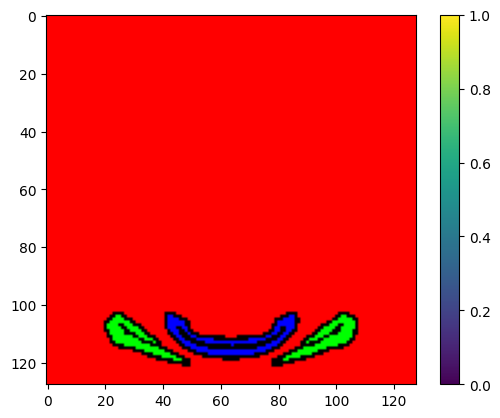

In [33]:
# Display mask & its info.
plt.imshow(msk)
plt.colorbar()
print_image_data(msk)

# One hot encoding & resizing

In [35]:
# Load the data without any transformations - raw numpy arrays.
train_set=dataset.SegMaskDataset(data_dir,mask_dir,train_image,eval_image,train=True)

In [36]:
sample = train_set[3]
msk = sample['mask']

Shape of input image:  (128, 128, 3)
Data type:  uint8
Max element:  254
Min element:  0
Total number of elements:  49152
Number of unique elements:  202
Average value:  6.0404052734375


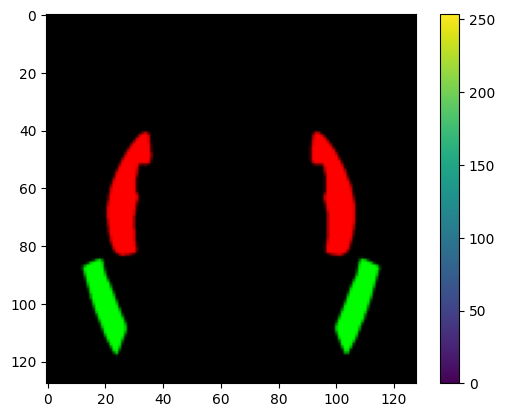

In [37]:
# Display mask & its info.
plt.imshow(msk)
plt.colorbar()
print_image_data(msk)

In [38]:
np.unique(msk)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  49,  50,  51,  52,  53,
        54,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  67,  69,
        72,  73,  76,  77,  78,  79,  81,  82,  83,  84,  85,  86,  92,
        93,  94,  95,  96,  97,  98, 100, 103, 104, 106, 109, 113, 114,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 131,
       134, 136, 137, 138, 140, 142, 144, 145, 146, 148, 149, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 165, 168, 169,
       170, 172, 173, 176, 177, 179, 180, 181, 182, 183, 185, 186, 188,
       190, 191, 192, 193, 194, 196, 197, 198, 199, 200, 201, 203, 204,
       205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 223, 225, 226, 227, 228, 229, 230, 231, 23

In [40]:
COLOR_DICT = {
    0: (0, 0, 0), # largest - red
    1: (255, 0, 0),  # background - black
    2: (0, 255, 0),  # second_largest - green
}

In [41]:
msk.shape

(128, 128, 3)

In [44]:
msk = onehot_to_rgb(msk, COLOR_DICT)

Shape of input image:  (128, 128, 3)
Data type:  uint8
Max element:  255
Min element:  0
Total number of elements:  49152
Number of unique elements:  2
Average value:  4.92340087890625


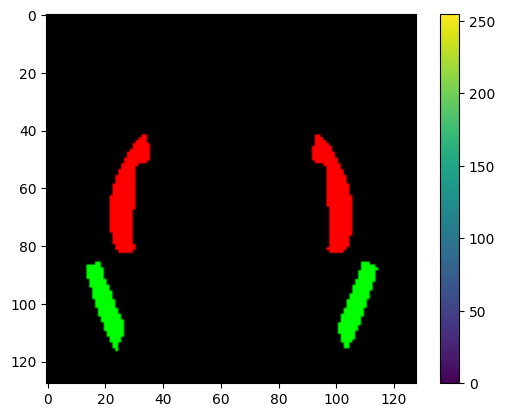

In [45]:
# Display mask & its info.
plt.imshow(msk)
plt.colorbar()
print_image_data(msk)

In [46]:
# Perform one-hot-encoding & resize.
msk = rgb_to_onehot(msk, COLOR_DICT)
msk=trans.resize(msk,(config_file.config["output_size"], config_file.config["output_size"]), preserve_range=True)

Shape of input image:  (128, 128, 3)
Data type:  float64
Max element:  1.0
Min element:  0.0
Total number of elements:  49152
Number of unique elements:  2
Average value:  0.3333333333333333


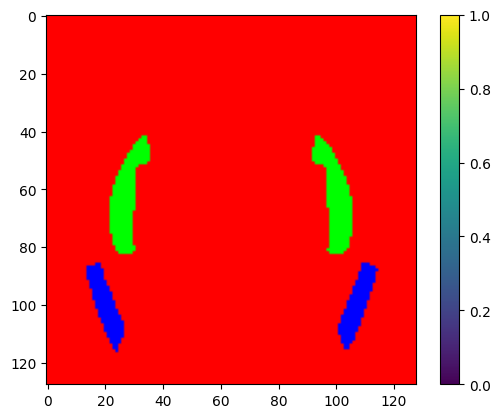

In [47]:
# Display mask & its info.
plt.imshow(msk)
plt.colorbar()
print_image_data(msk)

# Aspect ratio

In [ ]:
# Determine the average aspect ratio of the data set.
# Load the data without any transformations - raw numpy arrays.
train_set=dataset.SegMaskDataset(data_dir,mask_dir,train_image,eval_image,train=True)
aspect_ratios = []
widths = []
heights = []
for sample in train_set:
    img=sample['image']
    aspect_ratios.append(img.shape[0]/img.shape[1])
    heights.append(img.shape[0])
    widths.append(img.shape[1])

In [ ]:
plt.imshow(img)
print("Average aspect ratio of the data set: ", np.round(np.average(aspect_ratios), 2))
print("Average height of the data set: ", np.round(np.average(heights), 2))
print("Average width of the data set: ", np.round(np.average(widths), 2))